- Use detected spike from median
- use SVR

**Observation**
- whitening can help recover more spike cluster, but it is not necessary for decoding
- The choice of decoder has a larger effect if the sorting is not very accurate
- Whitening also has the effect of normalizing the signal amplitude


In [86]:
%reload_ext autoreload
%autoreload 2
# %load_ext rpy2.ipython

from online_sorter_qtui import spike_data
from pyneurode.spike_sorter import *
import numpy as np 
import pickle
from sklearn import metrics
from tqdm.notebook import tqdm
import seaborn as sns

import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

from scipy import signal 

from sklearn import *

from palettable.colorbrewer.qualitative import Dark2_4 as p4color

from utils import *

from time import sleep

# %R require(ggplot2)
# %R require(repr)

In [3]:
# load data
def loadPackets(filename):

    data_list = []
    segment_count = 0
    with open(filename,'rb') as f:
        while True:
            try:
                data_list.append(pickle.load(f))
                segment_count +=1
            except EOFError:
                break

        print(f'Reached end. Total segment: {segment_count}')
    return data_list

data_list = loadPackets('data/data_packets_M2_D23_3.pkl')
data_list = [d for d in data_list if d]

Reached end. Total segment: 126868


In [4]:
Fs = 30000
spikes_data = [d['spike'] for d in data_list if 'spike' in d.keys()]
df_spikes = makeSpikeDataframe(spikes_data)
df_spikes.sort_values('timestamps',inplace=True)
print(len(df_spikes))
df_spikes.head()


111089


spike_waveform  \
0  [-5.7485013, -5.5810714, -11.215428, -16.83687...   
1  [-27.44911, -39.954662, -38.020676, -28.24411,...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                time  electrode_ids  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              2   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              0   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   

                                         channel_ids  spike_id  timestamps  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0       10081  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         1       10197  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         2       10365  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         3       10409  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         4       10439

(27, 9413760)
8960


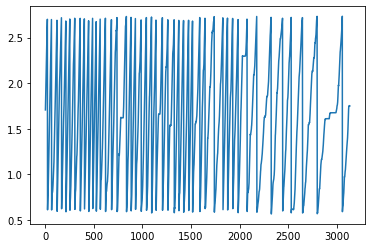

In [5]:
# collect the animal position
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
data_ts = [d['data_timestamp'] for d in data_list if 'data_timestamp' in d ]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_ts[0]
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

neuroData = adc_data[:16,:]


In [36]:
# whiten the matrix
W = compute_whitenMatrix(neuroData[:,:10*30000])
neuroData_w = applyWhitening(neuroData,W)
# plt.figure(figsize=(18,15))
# plot_multichannel(neuroData[:,:30000],scale=20)

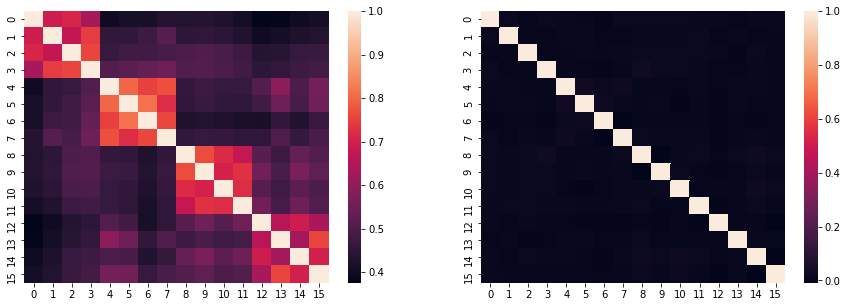

In [41]:
fig,ax = plt.subplots(1,2,figsize=(5*3,5))
c= np.corrcoef(neuroData)
sns.heatmap(c,ax=ax[0])

c = np.corrcoef(neuroData_w)
sns.heatmap(c,ax=ax[1])

### Don't use any spike sorting, directly use the firing rate

In [93]:
spike_time_fr = detectSpikePerChannel(neuroData_w,factor=4)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.21it/s]


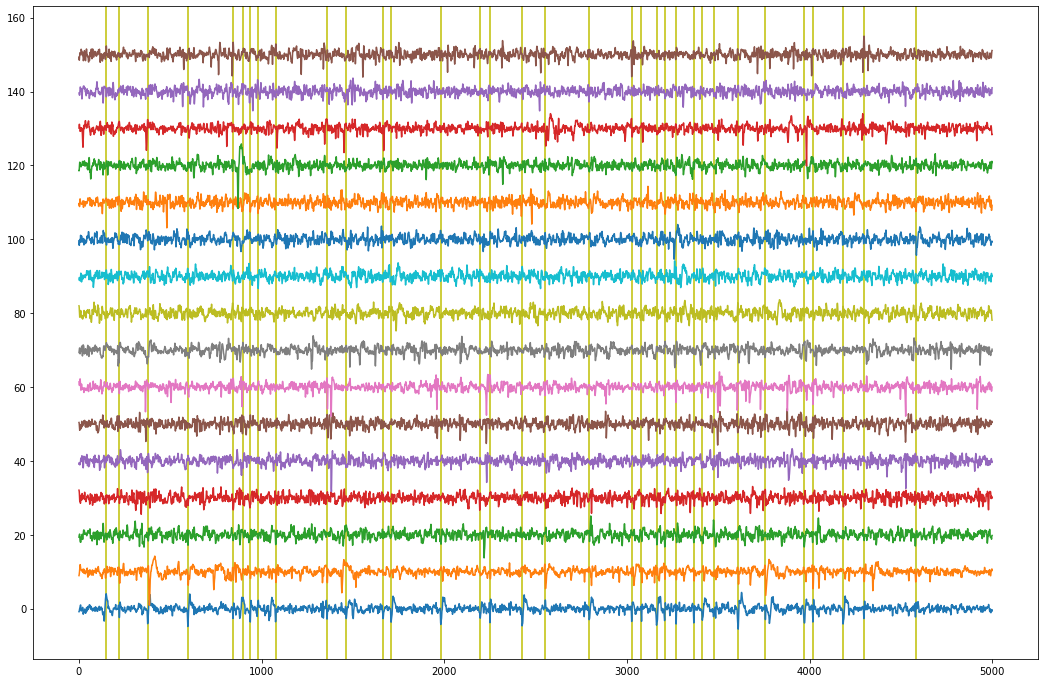

In [94]:
plot_spikeEvent(neuroData_w,spike_time_fr[0],5000,figsize=(18,12),color='y')

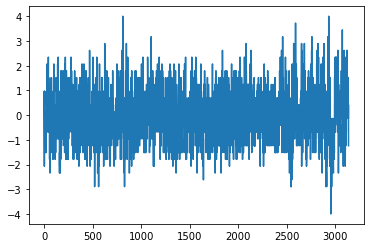

In [99]:
# don't do any spike sorting, directly use the firing rate as feature

bins = np.arange(0, adc_data.shape[1]/Fs, time_bin )

spiketrain_fr=[]
for i in range(len(spike_time_fr)):
    spiketime = spike_time_fr[i]
    spk_train = spiketime/Fs #convert to s
    spiketrain_fr.append(np.histogram(spk_train,bins)[0])
    
spiketrain_fr=np.stack(spiketrain_fr)
norm_spiketrain_fr = scaler.fit_transform(spiketrain_fr.T)

plt.plot(norm_spiketrain_fr[:,0])

In [95]:
### Extract waveform from each electrode for later spike sorting

In [6]:

preSample = postSample = 20
spikes_list = detectSpike(neuroData,3)
print(len(spikes_list))
print(spikes_list[0])

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Spike threshold: [11.697504  11.794146  10.983353  10.912125  11.55934   11.65571
 11.6844845 12.212929   9.942194  10.383419  10.509521  10.590731
 11.599945  11.804559  11.296558  11.437419 ]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:37<00:00, 24.41s/it]

505767
electrode_id: 0, timestamp: 138, spikedata: (4, 40)


In [7]:
df = makeSpikeDataframe(spikes_list)
df = df.sort_values('timestamps').reset_index()
df

index                                     spike_waveform  \
0       363183  [5.3035336, -3.4177158, -8.443727, -4.7834344,...   
1       363184  [5.8765187, 9.31958, 14.370857, 17.718203, 16....   
2       253836  [21.967031, 20.638983, 18.9655, 17.695621, 16....   
3       253837  [10.464372, 16.050484, 18.25281, 12.27212, -4....   
4       363185  [8.292999, 9.697282, 7.2413397, 0.43432856, -2...   
...        ...                                                ...   
505762  505765  [-18.298006, -29.274164, -21.395004, -3.327911...   
505763  505766  [-12.7764635, -6.381998, -4.5917687, -5.610086...   
505764  253835  [2.2875865, 1.7025403, 4.078599, 1.5817484, -4...   
505765  129267  [-8.140845, -11.768929, -9.218016, 1.0204538, ...   
505766  129268  [1.8777158, -0.15916823, 7.752281, 18.402344, ...   

                                                     time  electrode_ids  \
0       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
1       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
2       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              2   
3       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              2   
4       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
...                                                   ...            ...   
505762  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
505763  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              3   
505764  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              1   
505765  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              0   
505766  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...              0   

                                              channel_ids  spike_id  \
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    363183   
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    363184   
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    253836   
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    253837   
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    363185   
...                                                   ...       ...   
505762  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    505765   
505763  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    505766   
505764  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    253835   
505765  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    129267   
505766  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    129268   

        timestamps  
0               22  
1               64  
2               68  
3              112  
4              116  
...            ...  
505762     9413530  
505763     9413617  
505764     9413639  
505765     9413652  
505766     9413687  

[505767 rows x 7 columns]

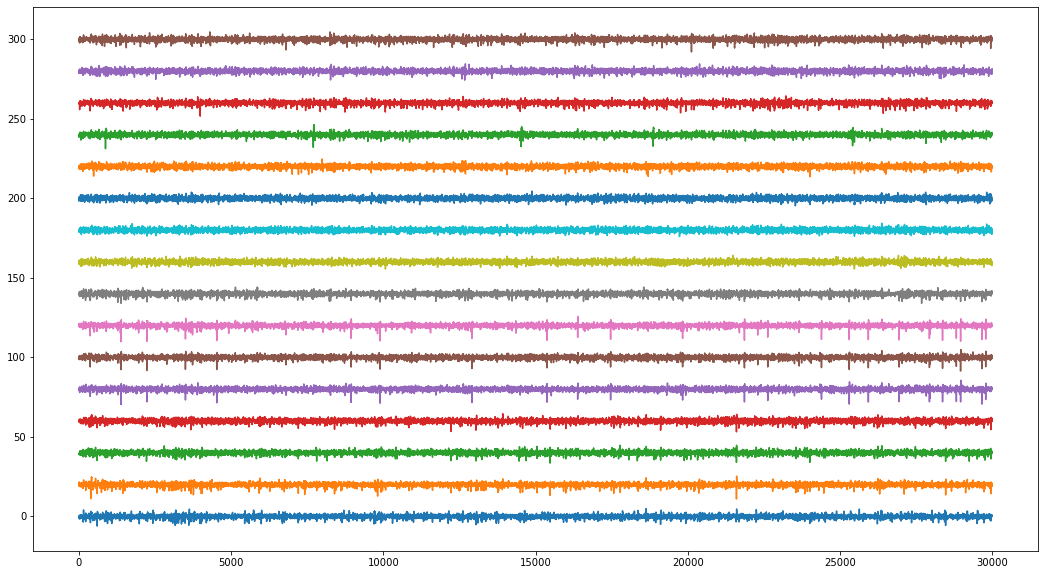

In [266]:
plt.figure(figsize=(18,10))
plot_multichannel(neuroData[:,:30000],scale=20)

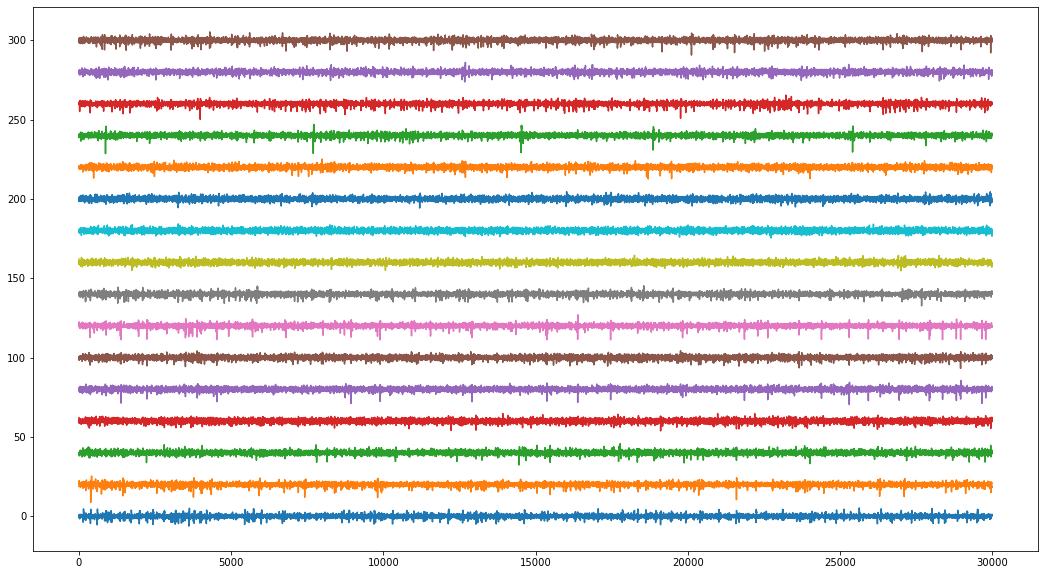

In [267]:
plt.figure(figsize=(18,10))
plot_multichannel(neuroData_w[:,:30000],scale=20)

In [317]:
eps_list = np.linspace(0.5,1.5,10)
pca_list = range(2,8)

rand_scores = np.zeros((len(eps_list), len(pca_list)))

pbar = tqdm(total = len(eps_list))
for i,eps in enumerate(eps_list):
    pbar.update()
    for j,pca_component in enumerate(pca_list):
        df_ref, df_online,template_cluster_id = sort_spikes_online(df_ms4, df_ms4,eps=eps, pca_component=pca_component)
        rand_scores[i,j] = metrics.adjusted_rand_score(df_ref.ms4_cluster, df_ref.cluster_id)
        

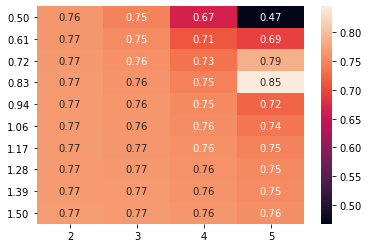

In [324]:
y_label =[f'{e:.2f}' for e in eps_list]
sns.heatmap(rand_scores,xticklabels=pca_list,yticklabels=y_label,annot=True)

In [140]:
# sort using DBSCAN
df_ref, df_online,template_cluster_id = sort_spikes_online(df.iloc[:10000], df,eps=1,pca_component=5)
print(template_cluster_id)

[0 1 2 3 4 5 6 7]


(8, 3137)
(3137, 8)


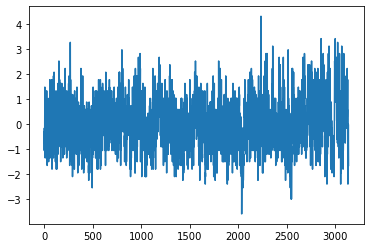

In [141]:
# make firing rate array
Fs = 30000
time_bin = 0.1
time_bin_start=0
spike_time = (df_online.timestamps.values)/Fs #shift timestamp
bins = np.arange(time_bin_start, spike_time.max(), time_bin )
spk_train, skp_time_event=sort2spiketrain(template_cluster_id, df_online.cluster_id_tm, spike_time, bins)
print(spk_train.shape)

# spk_train = spiketrain_ms4

#normalize the firing rate
scaler =preprocessing.StandardScaler()
meanFr = spk_train.mean(axis=1)
norm_spiketrain = scaler.fit_transform(spk_train[meanFr>0.1,:].T)
print(norm_spiketrain.shape)
# norm_spiketrain=spk_train.T
plt.plot(norm_spiketrain[:,0])

### Train decoder

In [142]:
norm_pos_online = position 
spiketrain2decode = norm_spiketrain

data_length = min(spiketrain2decode.shape[0], norm_pos_online.shape[0])
spiketrain2decode = spiketrain2decode[:data_length,:]
norm_pos_online = norm_pos_online[:data_length]

norm_pos_online = np.round((norm_pos_online-norm_pos_online.min())/(norm_pos_online.max()-norm_pos_online.min())*200)
norm_speed_online = np.diff(norm_pos_online.ravel(), prepend=norm_pos_online[0])
norm_speed_online[norm_speed_online<0]=0

0.2873280906033945 0.289193805632022


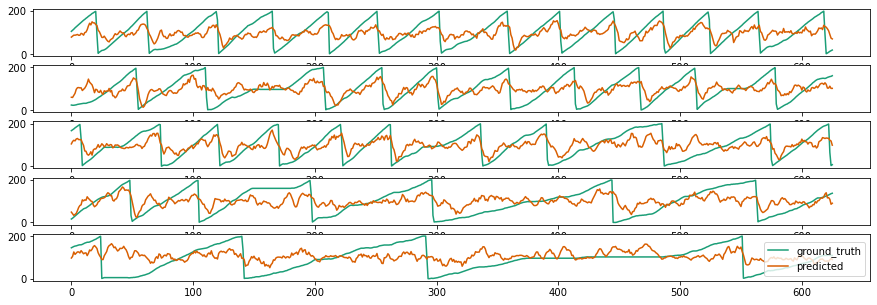

In [145]:
polyFeatures = preprocessing.PolynomialFeatures(1).fit(spiketrain2decode)
poly_spiketrain = polyFeatures.transform(spiketrain2decode)

# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,norm_pos_online)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')

# featureName = np.array(polyFeatures.get_feature_names())
# idx = np.argsort(-regressor.coef_**2) #sorted feature index, descending
# sortedFeatureName = featureName[idx]
# print(sortedFeatureName)

X = poly_spiketrain
y = norm_pos_online

predicted = model_selection.cross_val_predict(regressor,X,y.ravel(),cv=5)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(y.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(y.squeeze(),predicted_smooth.ravel())
print(r2,varExplain)
stripplot(y,predicted_smooth);


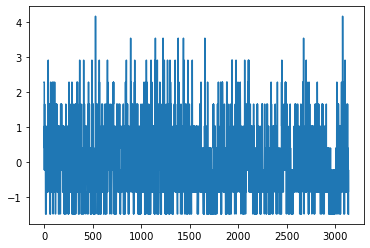

In [118]:
plt.plot(poly_spiketrain[:,featureName=='x1'])

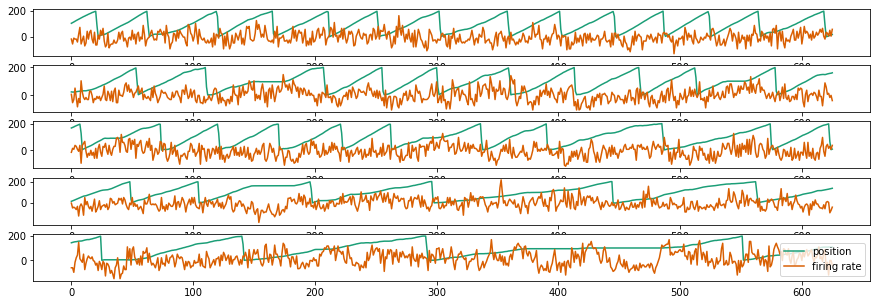

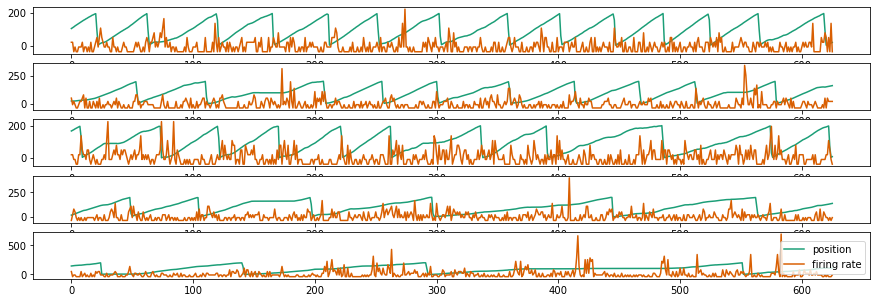

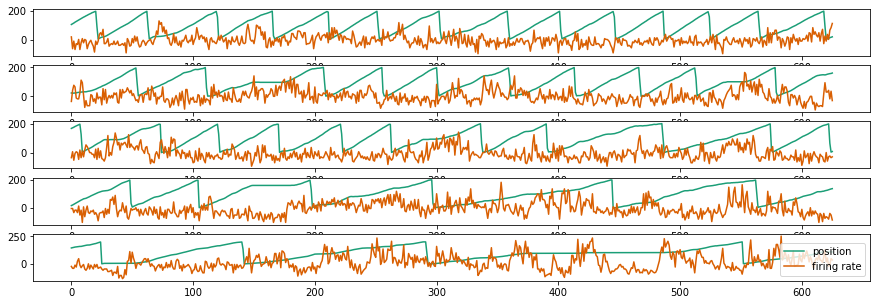

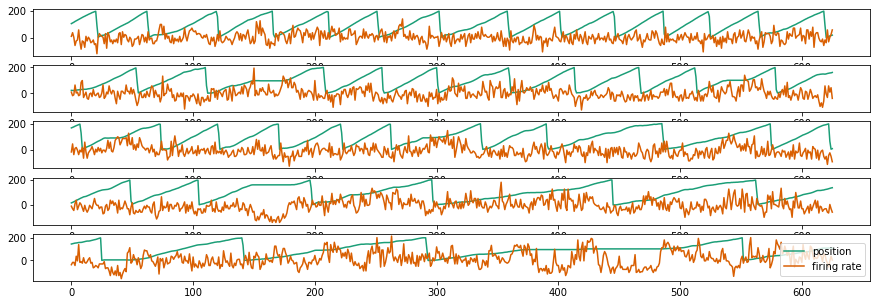

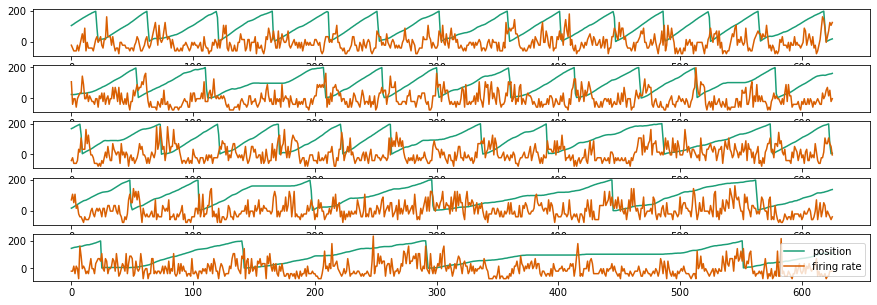

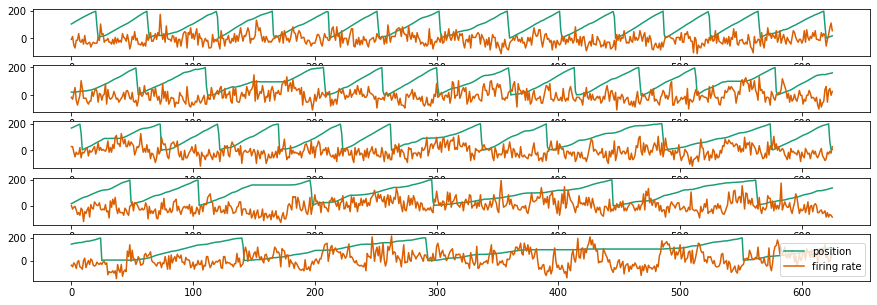

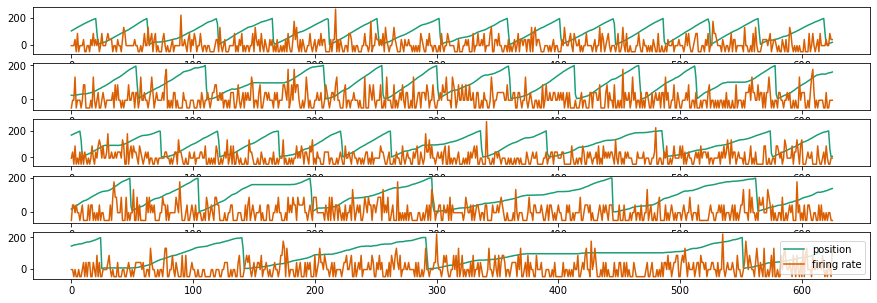

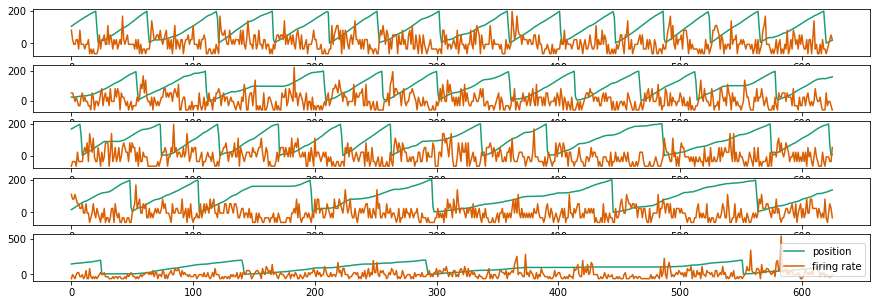

In [113]:
for i in range(spiketrain2decode.shape[1]):
    stripplot(norm_pos_online,spiketrain2decode[:,i]*50, first_label='position', second_label='firing rate');

In [96]:
time_bin_start = 0
start_timestamp = 0

bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain_ms4=np.stack(spiketrain)   

['x0' 'x0^2' 'x2' 'x0 x8' 'x0 x5' 'x7 x8' 'x8^2' 'x7' 'x4' 'x1' 'x0 x9'
 'x2 x8' 'x5 x9' 'x4 x5' 'x0 x2' 'x6 x7' 'x3 x4' 'x3 x5' 'x2 x5' 'x4 x9'
 'x2 x9' 'x4 x8' 'x1 x6' 'x8' 'x4 x6' 'x5 x7' 'x9' 'x2^2' 'x8 x9' 'x0 x4'
 'x5 x8' 'x2 x7' 'x5^2' 'x1^2' 'x0 x3' 'x9^2' 'x5 x6' 'x1 x5' 'x3' 'x3 x7'
 'x1 x9' 'x0 x7' 'x3 x6' 'x2 x6' 'x7 x9' 'x4^2' 'x5' 'x1 x7' 'x2 x4'
 'x1 x2' 'x6 x8' 'x1 x8' 'x6 x9' 'x3^2' 'x6^2' 'x7^2' 'x3 x8' 'x4 x7'
 'x3 x9' 'x1 x3' 'x1 x4' 'x2 x3' 'x0 x6' 'x0 x1' 'x6' '1']
[[1.        0.5572841]
 [0.5572841 1.       ]]


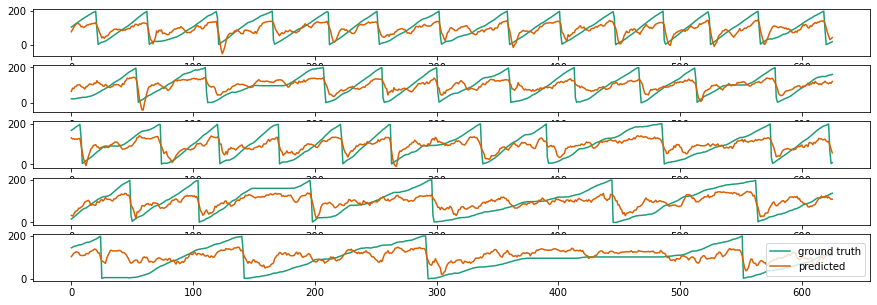

In [117]:
scaler =preprocessing.StandardScaler()
norm_spiketrain_ms4 = scaler.fit_transform(spiketrain_ms4.T)

# norm_pos = np.round((position-position.min())/(position.max()-position.min())*200)
norm_pos = norm_pos_online

datalength = min(norm_spiketrain_ms4.shape[0], norm_pos.shape[0])
norm_spiketrain_ms4 = norm_spiketrain_ms4[:datalength,:]
norm_pos = norm_pos[:datalength]


polyFeatures = preprocessing.PolynomialFeatures(2).fit(norm_spiketrain_ms4)
poly_spiketrain_ms4 = polyFeatures.transform(norm_spiketrain_ms4)
featureName = np.array(polyFeatures.get_feature_names())
idx = np.argsort(-regressor.coef_**2) #sorted feature index, descending
sortedFeatureName = featureName[idx]
print(sortedFeatureName)

regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain_ms4,norm_pos)

predicted_ms4 = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos,cv=4)
predicted_smooth = signal.savgol_filter(predicted_ms4.ravel(),5,1)


bestCoeff_ms4 = np.corrcoef(norm_pos.squeeze(),predicted_smooth.ravel())

print(bestCoeff)

stripplot(norm_pos,predicted_smooth);

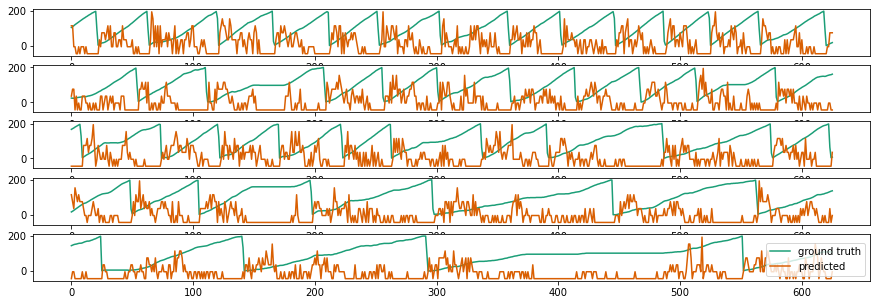

In [108]:
stripplot(norm_pos_online,poly_spiketrain_ms4[:,featureName=='x0']*50);
# plt.plot(poly_spiketrain_ms4[:,featureName=='x0'])

### use mountainsort for decoding

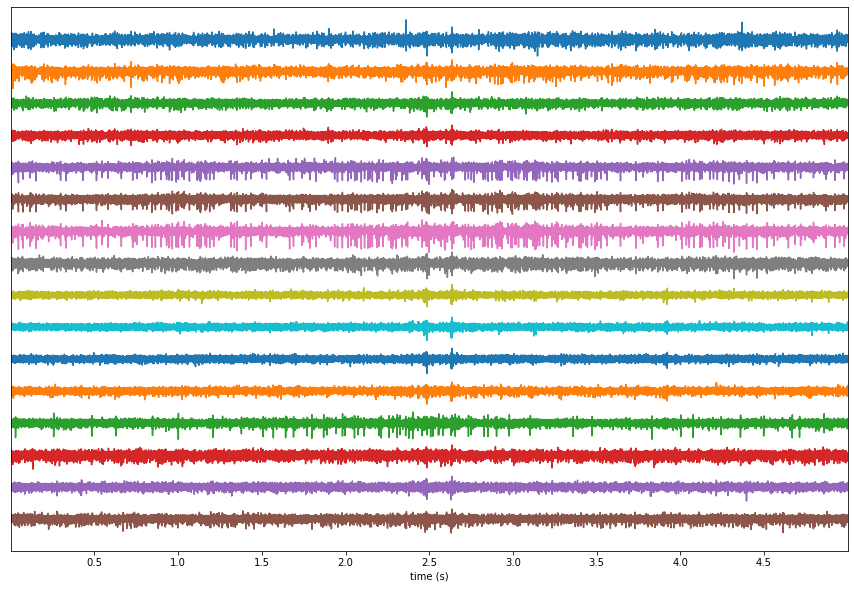

In [94]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

In [95]:
# sorting
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmpv6jfh44t
Num. workers = 2
Preparing C:\tmp\tmpv6jfh44t/timeseries.hdf5...
'end_frame' set to 9413760
Preparing neighborhood sorters (M=16, N=9413760)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmpv6jfh44t
mountainsort4 run time 110.04s


In [29]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())

[3, 5, 6, 9, 10, 16, 17, 27, 30, 31]
[3, 5, 6, 9, 10, 16, 17, 27, 30, 31]
[3, 5, 6, 9, 10, 16, 17, 27, 30, 31]


In [41]:
st.postprocessing.get_unit_max_channels(recording, sorting_ms4_curated, save_as_property=True)


[1, 1, 2, 3, 3, 6, 6, 11, 12, 12]

### Compare spike detection between mountainsort and median

In [33]:
# compare the spike detected in mounsort and median method
spiketime_ms4 = []
for i in sorting_ms4_curated.get_unit_ids():
    spiketime_ms4.append(sorting_ms4_curated.get_unit_spike_train(i))
spiketime_ms4 = np.sort(np.concatenate(spiketime_ms4))
spiketime_median = df.timestamps.values

#sync the spike time with data
df_spikes_sync = syncSpikeTime(df_spikes,neuroData,spikeIdx=0,searchLength=10000)
spiketime_online = np.sort(df_spikes_sync.timestamps.values)

Match found at 462


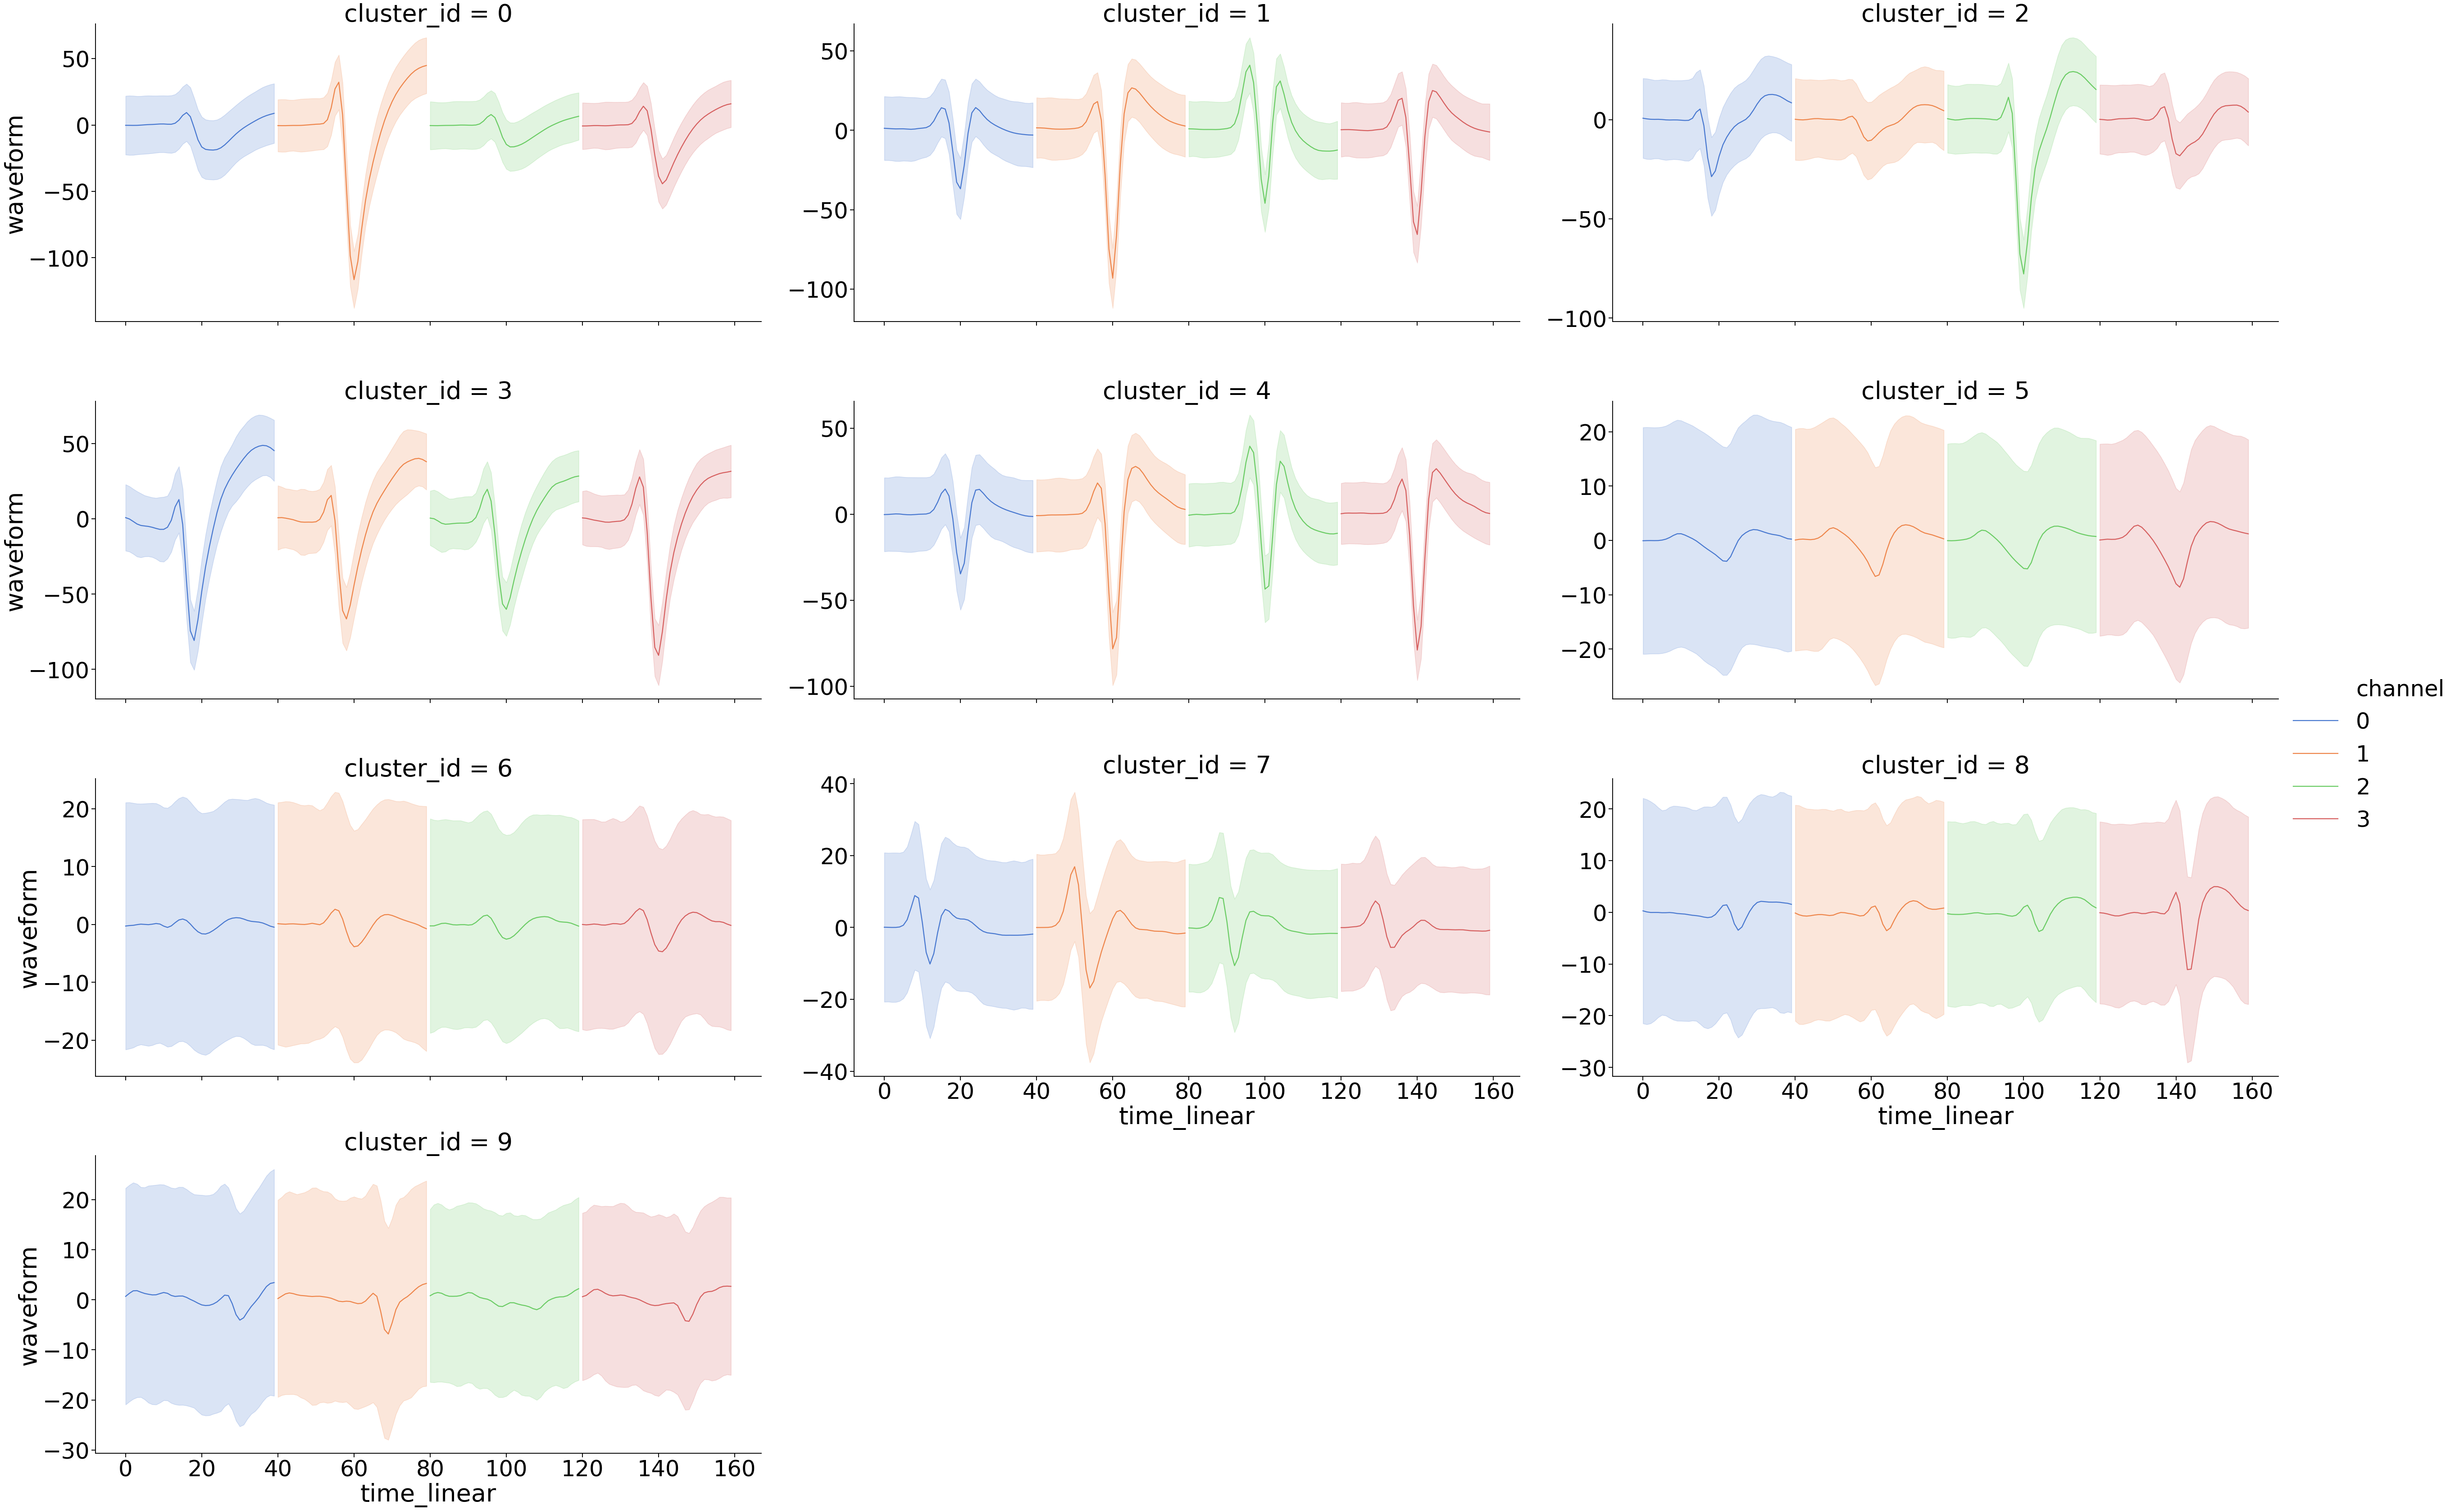

In [110]:
# plot the spike waveform

## Mountainsort
waveforms = []

for i in sorting_ms4_curated.get_unit_ids():
    spiketime = sorting_ms4_curated.get_unit_spike_train(i)
    max_channel = sorting_ms4_curated.get_unit_property(i,'max_channel')
    spikes = getSpikeWaveform(spiketime,max_channel//16,neuroData)
    waveforms.append(spikes)

df_waveforms = spikeWaveform2DF(waveforms)

sns.set_context('talk',font_scale=3)
sns.relplot(y='waveform',x ='time_linear', hue='channel', col='cluster_id',
            col_wrap=3, height=12, aspect=2,
            kind='line',ci='sd',facet_kws={'sharey':False},palette='muted',data=df_waveform)

plt.savefig('figures/mountainsort_waveform.png')

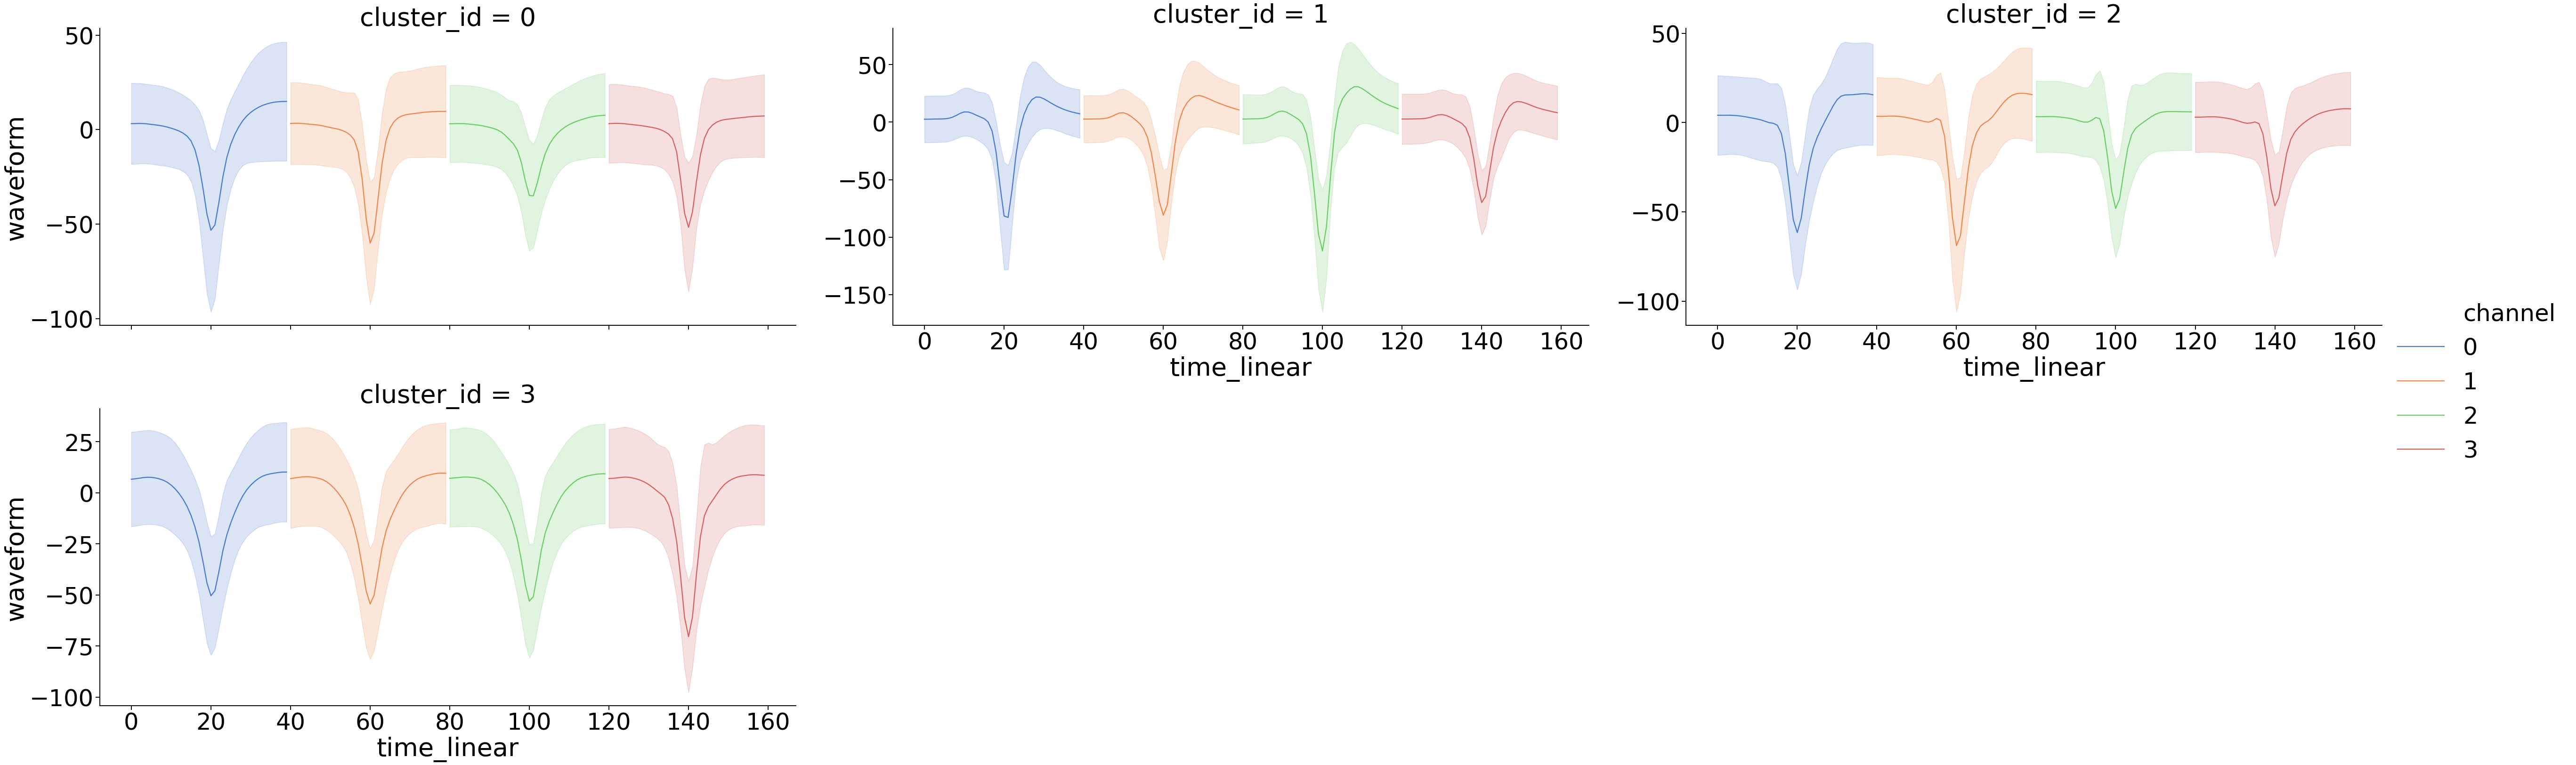

In [118]:
# offline spike detection
clusters = df_online.label_tm.unique()

waveforms = []

for c in clusters:
    spiketime = df_online[df_online.label_tm==c].timestamps
    electrode = df_online[df_online.label_tm==c].electrode_ids.values
    waveform = getSpikeWaveform(spiketime,electrode[0],neuroData)
    waveforms.append(waveform)
    
df_waveforms_median = spikeWaveform2DF(waveforms)

sns.set_context('talk',font_scale=3)
sns.relplot(y='waveform',x ='time_linear', hue='channel', col='cluster_id',
            col_wrap=3, height=12, aspect=2,
            kind='line',ci='sd',facet_kws={'sharey':False},palette='muted',data=df_waveforms_median)

plt.savefig('figures/median_spikedetect_waveform.png')

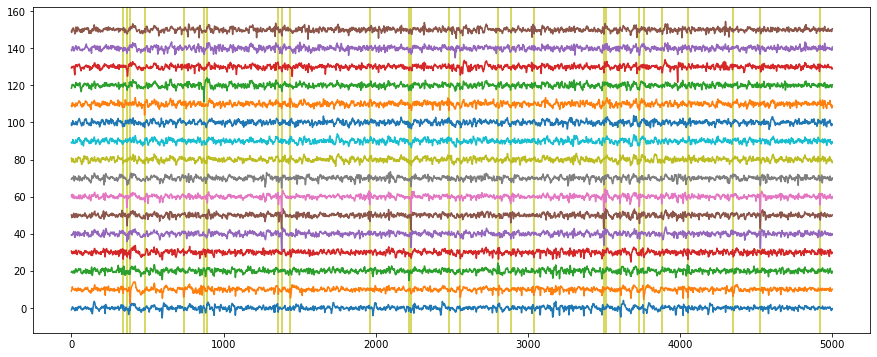

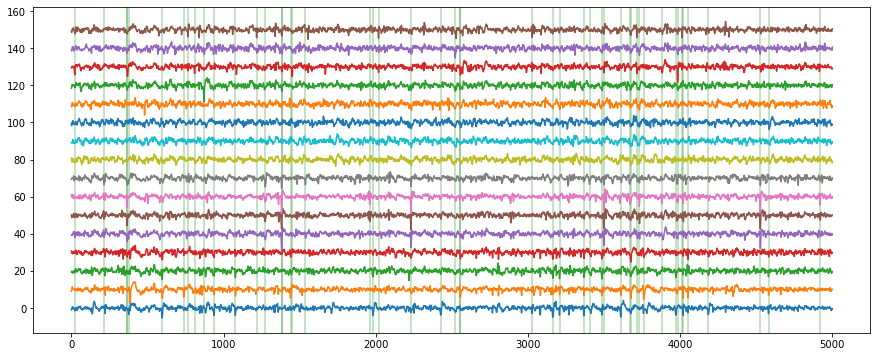

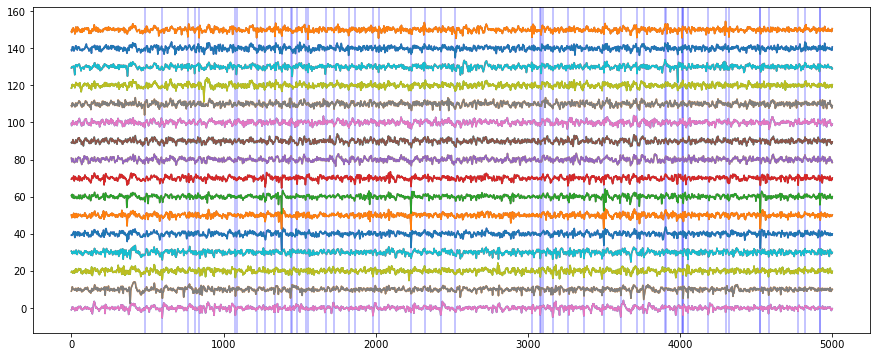

In [39]:
plot_range = 5000

plot_spikeEvent(neuroData,spiketime_ms4,plot_range,color='y',alpha=0.8)
plot_spikeEvent(neuroData,spiketime_median,plot_range,color='g',alpha=0.3)
plot_spikeEvent(neuroData,spiketime_online,plot_range,color='b',alpha=0.3)


plot_multichannel(neuroData[:,:plot_range],10)

In [248]:
data_list2 = loadPackets('data/data_packets_M2_D23_3.pkl')
adc_data2 = [d['data'] for d in data_list2 if 'data' in d]
spikes2 = [d['spike'] for d in data_list2 if 'spike' in d]
spiketimes2 = np.array([s.timestamp for s in spikes2])
adc_data2 = np.concatenate(adc_data2,1)
neurodata2 = adc_data2[:16,:]
plt.figure(figsize=(18,12))
# plot_multichannel(adc_data2[:16,:plot_range],10)

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import widgets

@interact(x=widgets.IntSlider(min=-3000, max=3000, step=1, value=0))
def shift_plot(x):
    plot_spikeEvent(adc_data2[:16,:],spiketimes2-x,1000,color='y')


Reached end. Total segment: 773


<Figure size 1296x864 with 0 Axes>

interactive(children=(IntSlider(value=0, description='x', max=3000, min=-3000), Output()), _dom_classes=('widg…

161


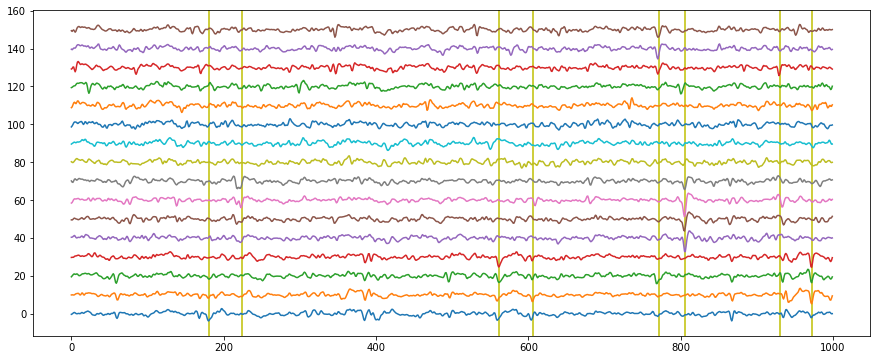

In [281]:
# match the timestamp of the data and spike

def findMatch(y,x):
    #match position of x in y
    for j in range(4):
        for i in range(y.shape[1]-x.shape[1]):
            if np.allclose(y[j:j+4,i:i+x.shape[1]],x):
                return i
          
first_spike_data = spikes2[0].data
match_idx = findMatch(neurodata2,first_spike_data)
first_spike_time = spikes2[0].timestamp

spike_time_sync = spiketimes2-first_spike_time+match_idx+first_spike_data.shape[1]/2

print(match_idx)

plot_spikeEvent(adc_data2[:16,:],spike_time_sync,1000,color='y')

{'n_channels': 4, 'n_samples': 40, 'electrode_id': 0, 'sorted_id': 0, 'timestamp': 1460, 'channel': 0, 'threshold': 5, 'source': 106}


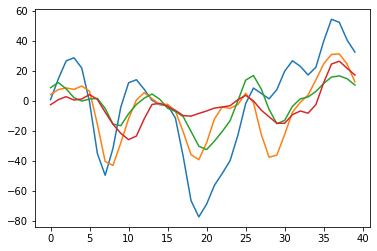

In [245]:
print(spikes2[0])
plt.plot(spikes2[0].data.T);



In [256]:
# try to search for the matching spikes
x = spikes2[0].data
y=neurodata2[:,:5000]

def findMatch(y,x):
    #match position of x in y
    for j in range(4):
        for i in range(y.shape[1]-x.shape[1]):
            if np.allclose(y[j:j+4,i:i+x.shape[1]],x):
                return i


# np.correlate(y,x)
# plt.plot(np.correlate(y,x))
# plt.xlim([0,5000])

In [258]:
%timeit findMatch(y,x)

4.47 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [169]:
spikes2[:5]

[{'n_channels': 4, 'n_samples': 40, 'electrode_id': 1, 'sorted_id': 0, 'timestamp': 2, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 0, 'sorted_id': 0, 'timestamp': 4, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 1, 'sorted_id': 0, 'timestamp': 116, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 3, 'sorted_id': 0, 'timestamp': 694, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40),
 {'n_channels': 4, 'n_samples': 40, 'electrode_id': 3, 'sorted_id': 0, 'timestamp': 800, 'channel': 0, 'threshold': 5, 'source': 106} Spike data shape:(4, 40)]

### Decoding

In [36]:
time_bin_start = 0
start_timestamp = 0

bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain_ms4=np.stack(spiketrain)   

[[1.         0.23287466]
 [0.23287466 1.        ]]


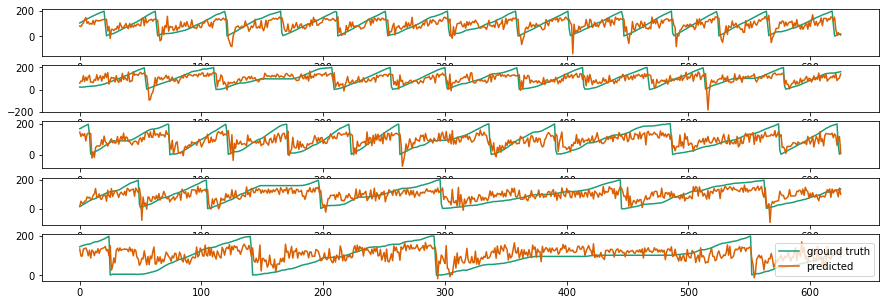

In [37]:
scaler =preprocessing.StandardScaler()
norm_spiketrain_ms4 = scaler.fit_transform(spiketrain_ms4.T)

norm_pos = np.round((position-position.min())/(position.max()-position.min())*200)

datalength = min(norm_spiketrain_ms4.shape[0], norm_pos.shape[0])
norm_spiketrain_ms4 = norm_spiketrain_ms4[:datalength,:]
norm_pos = norm_pos[:datalength]

poly_spiketrain_ms4 = preprocessing.PolynomialFeatures(2).fit_transform(norm_spiketrain_ms4)
# poly_spiketrain_ms4 = polyFeatures_ms4.transform(norm_spiketrain_ms4)
lasso_ms4 = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain_ms4,norm_pos)

predicted_ms4 = model_selection.cross_val_predict(lasso_ms4,poly_spiketrain_ms4,norm_pos,cv=4)
bestCoeff_ms4 = np.corrcoef(norm_pos.squeeze(),predicted_ms4)
print(bestCoeff)

stripplot(norm_pos,predicted_ms4);

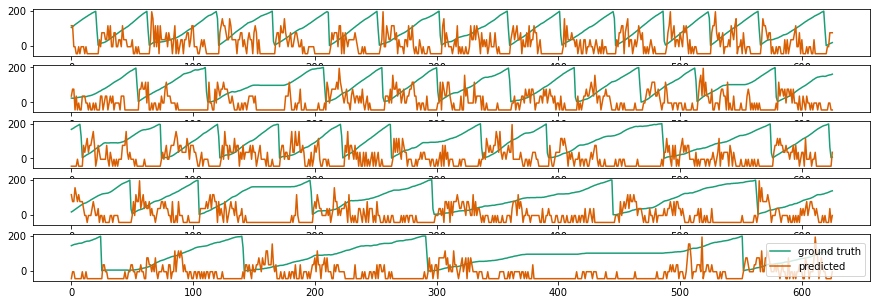

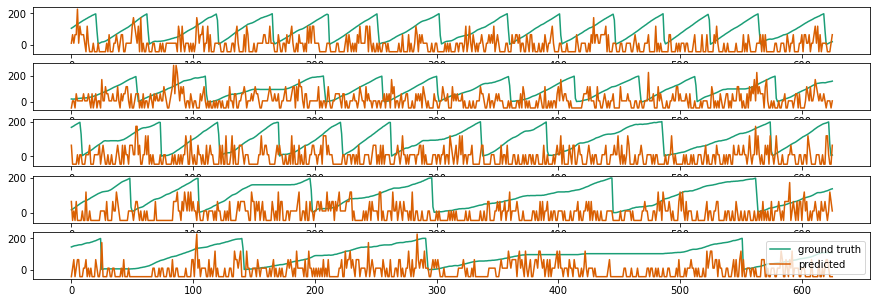

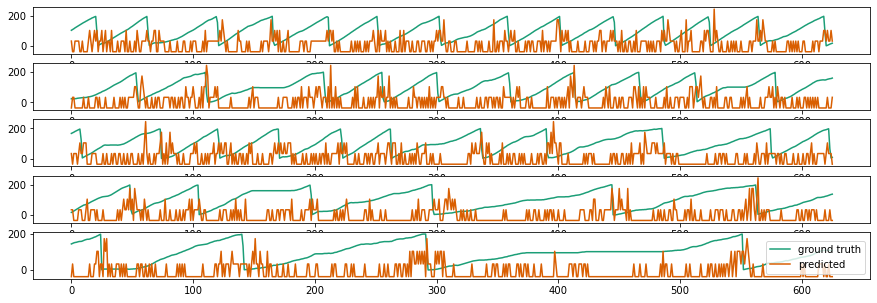

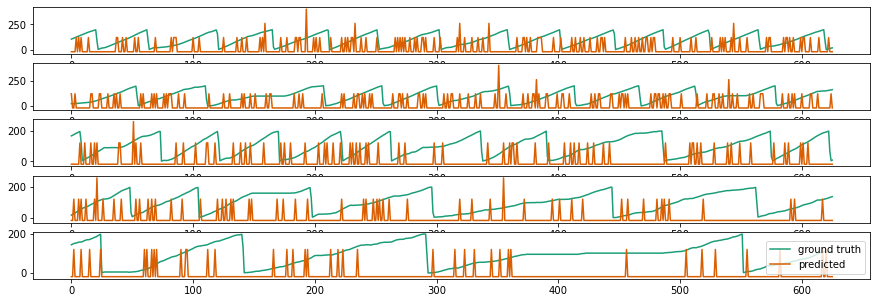

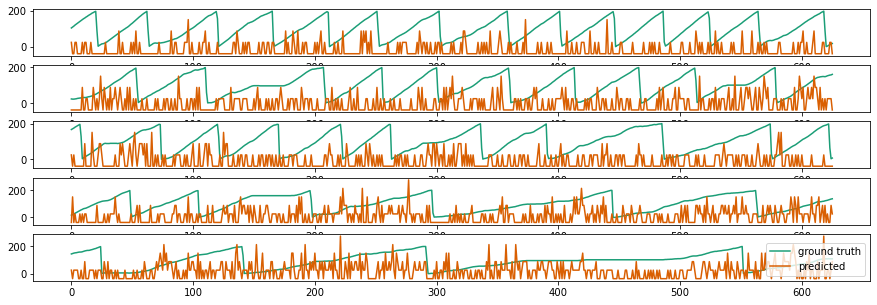

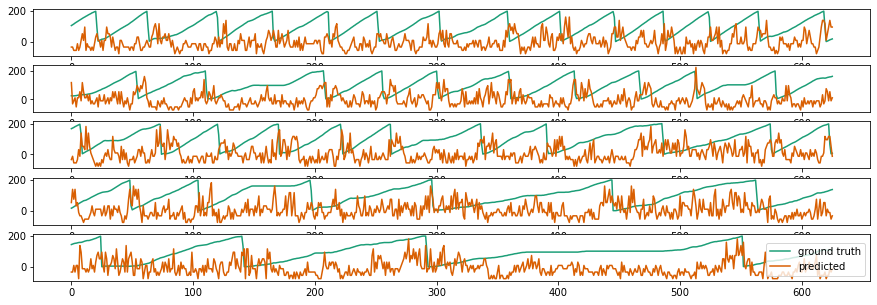

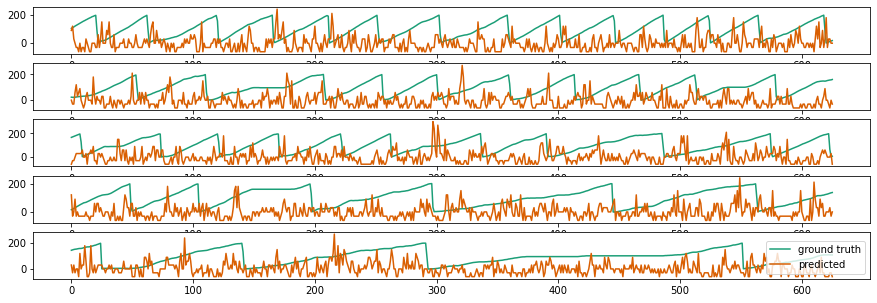

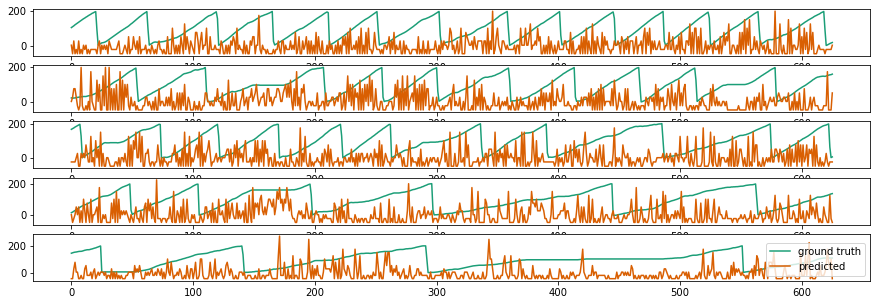

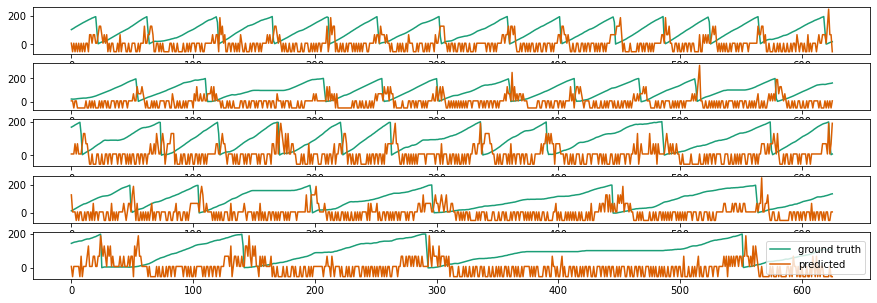

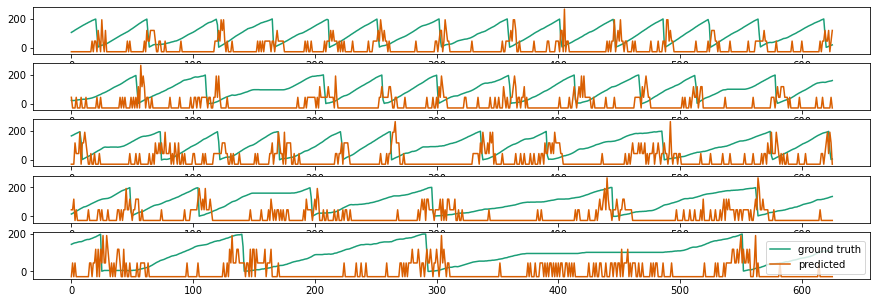

In [38]:
for i in range(norm_spiketrain_ms4.shape[1]):
    stripplot(norm_pos,norm_spiketrain_ms4[:,i]*50);

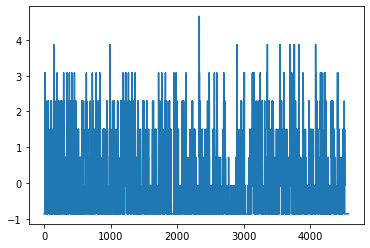

In [43]:
plt.plot(norm_spiketrain_ms4[:,2])

In [44]:
df_decoded = pd.read_pickle('data/decoded_data.pkl')

In [47]:
df_decoded.sort_values('meanScore',ascending=False)

model                                  sortedFeatureName  \
112  Lasso(alpha=0.1)  [x2, x0, x3, x10, x12, x2^2, x9, x13, x15, x2 ...   
120  Lasso(alpha=0.1)  [x2, x14, x9, x8, x2^2, x2 x14, x3, x14^2, x9 ...   
97   Lasso(alpha=0.1)  [x3, x15, x16, x3^2, x3 x16, x14, x17, x19, x2...   
121  Lasso(alpha=0.1)  [x15, x16, x5 x15, x10, x1, x10 x14, x13 x15, ...   
105  Lasso(alpha=0.1)  [x8, x3, x0, x4, x0 x5, x5 x8, x8^2, x3 x8, x2...   
..                ...                                                ...   
0    Lasso(alpha=0.1)                                      [x0, x0^2, 1]   
94   Lasso(alpha=0.1)  [x5, x2, x6, x4, x1, x5 x8, x5^2, x8, x6 x8, x...   
31   Lasso(alpha=0.1)  [x4, x2, x3, x1, x5, x5^2, x1 x3, x2^2, x3 x5,...   
84   Lasso(alpha=0.1)  [x12, x7, x13, x8, x10, x7 x12, x5, x6, x11, x...   
48   Lasso(alpha=0.1)  [x11, x10, x9, x2, x1, x5, x0, x2 x9, x3, x4, ...   

       meanScore                                             scores  \
112     0.390540  [0.20939310126147365, 0.26086171584513046, 0.2...   
120     0.370806  [0.18506497320448698, 0.18449288057857466, 0.2...   
97      0.334787  [0.24008593355009583, 0.25857119736991124, 0.2...   
121     0.331282  [0.11670965287913677, 0.1333439467175645, 0.16...   
105     0.293779  [0.1996118438120077, 0.1989804616260172, 0.250...   
..           ...                                                ...   
0    -283.903591         [-241.30446237785492, -283.90359116203456]   
94   -453.546058  [-214.41636449955573, -453.5460576483923, -470...   
31   -493.398021  [-261.2327942672108, -493.398021304907, -772.6...   
84  -2940.240539  [-2447.0034090795916, -2456.564698315384, -226...   
48  -5618.663693  [-5825.793639835601, -5109.367871926325, -5618...   

     bestNumfeature                                session  
112              66    cohort_4:M2_D23_2019-04-03_13-34-00  
120             101    cohort_4:M2_D25_2019-04-05_12-44-59  
97               85    cohort_4:M2_D24_2019-04-04_13-22-05  
121              98    cohort_4:M2_D27_2019-04-09_13-04-27  
105              28    cohort_4:M2_D16_2019-03-25_13-22-42  
..              ...                                    ...  
0                 1  cohort_2:1124_D10_2018-10-29_11-12-49  
94                1    cohort_3:M1_D21_2018-10-16_11-54-11  
31                1    cohort_2:245_D3_2018-10-20_10-56-04  
84                3    cohort_3:M1_D25_2018-10-19_13-01-11  
48                2     cohort_3:M1_D7_2018-09-14_13-13-03  

[152 rows x 6 columns]

In [54]:
df_decoded[df_decoded.session.str.match('.*M1_D4.*')]

model                                  sortedFeatureName  \
92  Lasso(alpha=0.1)  [x2, x1, x1 x2, x3, x1 x3, x2^2, x3^2, x0 x2, ...   

    meanScore                                             scores  \
92   0.021963  [0.01994906820348765, 0.02211494862908987, 0.0...   

    bestNumfeature                             session  
92               2  cohort_3:M1_D4_2018-09-09_12-09-53

## tuning curves

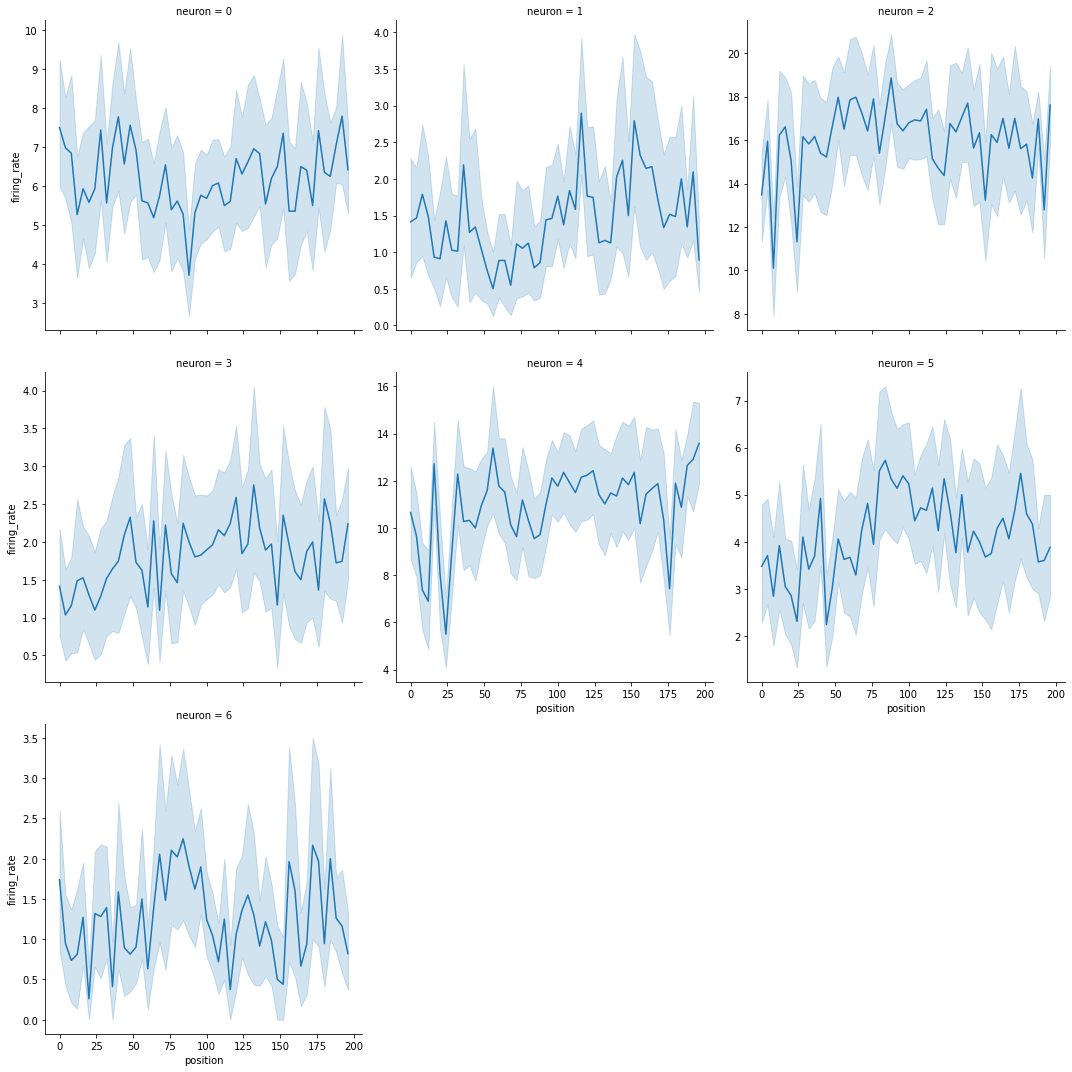

In [140]:
# calculate tuning curve

df_online_tc = makeTuningDataframe(position,spk_train.T,time_bin)

sns.relplot(x='position',y='firing_rate',col='neuron',col_wrap=3, kind="line",
    facet_kws = {'sharey':False},data=df_online_tc)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



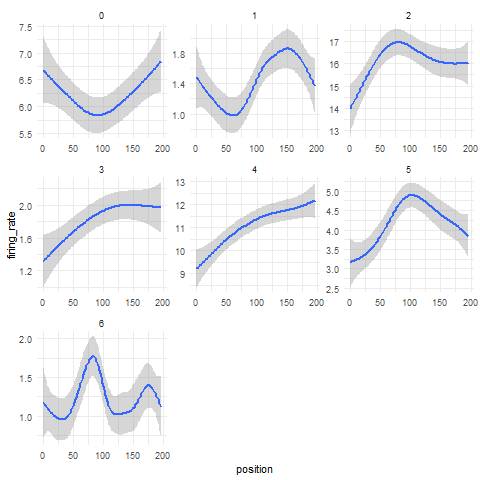

In [141]:
%%R -i df_online_tc
ggplot(df_online_tc) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
# ggsave('online_tuningcurve.pdf')

## Offline sorting using spike interface

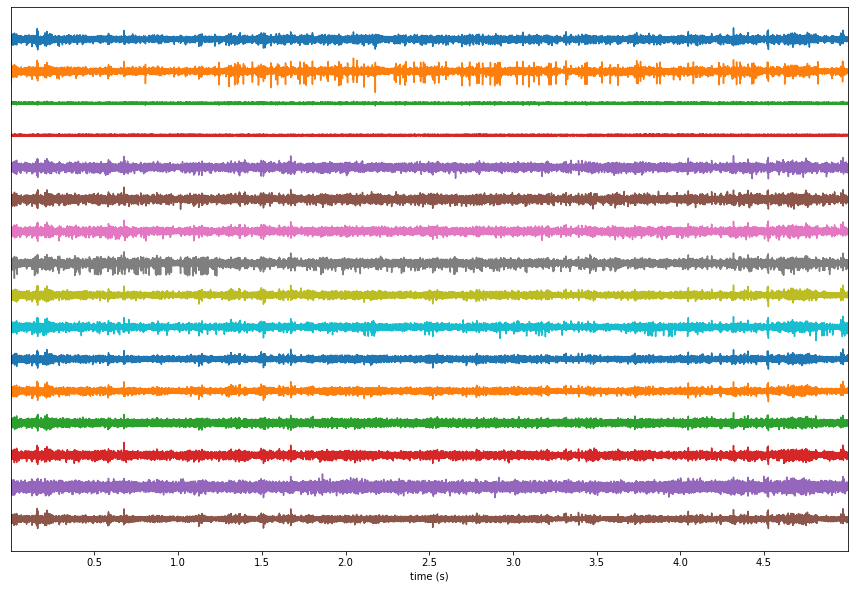

In [142]:
neuroData = adc_data[:16,:]
recording = se.NumpyRecordingExtractor(timeseries=neuroData,sampling_frequency=Fs)
recording.load_probe_file('tetrode_16.prb')
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
fig,ax = plt.subplots(figsize=(15,10))
sw.plot_timeseries(recording_f,trange=[0,5],ax=ax);

In [143]:
 #required for mountasort to store intermediate data
%env TEMPDIR=C:\tmp
ms4_params = ss.get_default_params('mountainsort4')
ms4_params['curation']=True
ms4_params['adjust_radius']  = 100
sorting_MS4_2 = ss.run_mountainsort4(recording=recording,output_folder='sorting_tmp',verbose=True)

env: TEMPDIR=C:\tmp
WARNING! No channel location given. Add dummy location.
Using 2 workers.
Using tmpdir: C:\tmp\tmp6fpmdcde
Num. workers = 2
Preparing C:\tmp\tmp6fpmdcde/timeseries.hdf5...
'end_frame' set to 13849600
Preparing neighborhood sorters (M=16, N=13849600)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: C:\tmp\tmp6fpmdcde
mountainsort4 run time 145.57s


In [144]:
# curation
sorting_ms4_curated = st.curation.threshold_snrs(sorting=sorting_MS4_2, recording = recording,
  threshold = 4, threshold_sign='less',
    max_snr_spikes_per_unit=100, apply_filter=False) #remove when less than threshold
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_firing_rates(sorting_ms4_curated,
    threshold=0.5, threshold_sign='less', duration_in_frames=recording.get_num_frames())
print(sorting_ms4_curated.get_unit_ids())

sorting_ms4_curated=st.curation.threshold_isi_violations(sorting_ms4_curated, 
    threshold = 0.9,duration_in_frames=recording.get_num_frames(), threshold_sign='greater' )
print(sorting_ms4_curated.get_unit_ids())


Impossible to delete temp file: C:\Users\teristam\AppData\Local\Temp\tmpbjb6p_g6 Error [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\teristam\\AppData\\Local\\Temp\\tmpbjb6p_g6\\waveforms_1.raw'
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]
[2, 4, 8, 9, 10, 12, 14, 15, 17, 20, 22, 23, 26, 27]


In [145]:
time_bin_start = 0
bins = np.arange(time_bin_start, adc_data.shape[1]/Fs, time_bin )

# extract the spike train, and bin it in time
spiketrain = []
for i in sorting_ms4_curated.get_unit_ids():
    spk_train = sorting_ms4_curated.get_unit_spike_train(i)
    spk_train = (spk_train - start_timestamp)/Fs #convert to s
    spiketrain.append(np.histogram(spk_train,bins)[0])

spiketrain=np.stack(spiketrain)    

# make frame for plotting
df_ms4 = makeTuningDataframe(position, spiketrain.T,time_bin)


R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



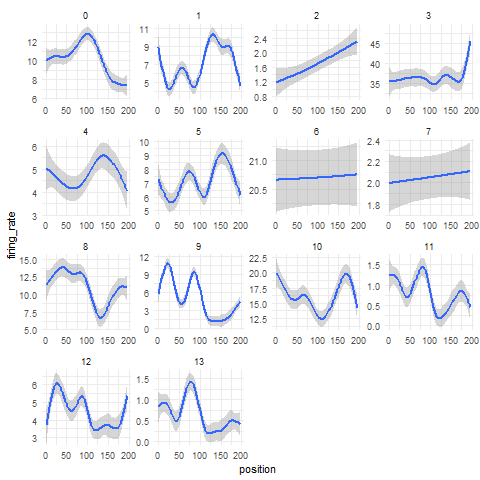

In [146]:
%%R -i df_ms4
options(repr.plot.width=12, repr.plot.height=8)

ggplot(df_ms4) +
    geom_smooth(aes(x=position,y=firing_rate)) +
    facet_wrap(~neuron,scale='free') +
    theme_minimal()
    
# ggsave('ms4_tuningcurve.pdf')